In [1]:
def functionality_and_features():
    """
    Current Kaggle Allstate Ranking: 526/1814, 29%
    
    graph ypred vs ytest
    restrict target range
    partition data ==> ensemble
    In Progress: kbest, recursive elimination
    
    feature voting
    target transformation
    feature transformations
    
    multiple feature selection passes ==> 2x, 3x
    
    DONE: load libraries and data
    DONE: define model parameters
    DONE: definte machine learning algorithm
    DONE: define performance metric
    DONE: shuffle and slice data
    In Progress: preprocess features ==> convert categorical variables to dummy variables
    DONE: plot feature importance
    DONE: feature selection

    Functionality/Features to Add:

    Outliers Approach #1
    create binary reponse variable for outliers
    use logistic regression to predict probabilities
    predictions = probabilities * average value for outliers

    Outliers Approach #2
    log transform target variable
    norm transform target variable

    Outliers Approach #3
    remove outliers from training data
    train on remaining 95% of data
    """

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import ShuffleSplit, train_test_split ## model_selection
from sklearn.cross_validation import StratifiedKFold, KFold ## model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.learning_curve as curves ## model_selection
from sklearn.grid_search import GridSearchCV ## model_selection
from sklearn.feature_selection import RFECV
from math import exp, log
#import xgboost as xgb

%matplotlib inline

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print('\n Time taken: %i minutes and %s seconds.' % (tmin, round(tsec, 2))),'\n'
        
def scale_data(X, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

def performance_metric(y_true, y_predict):
    score = -np.mean(np.abs((y_true-y_predict)))
    return score

C:\Users\Jason\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Jason\Anaconda2\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Users\Jason\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def load_data(fix_skew, rec_feature_sel):
    train_loader = pd.read_csv('input/train.csv', dtype={'id': np.str})
    test_loader = pd.read_csv('input/test.csv', dtype={'id': np.str})

    train = train_loader.drop(['id', 'loss'], axis=1)
    test = test_loader.drop(['id'], axis=1)

    ntrain = train.shape[0]
    ntest = test.shape[0]
    train_test = pd.concat((train, test)).reset_index(drop=True)

    all_features = [x for x in train.columns]
    num_features = train_test.dtypes[train_test.dtypes != 'object'].index
    skew_features = train_test[num_features].apply(lambda x: skew(x.dropna()))
    print '\nAverage Skew:',np.round(np.mean(np.abs(skew_features)),2)
    
    if fix_skew:
        #skew_features = skew_features[skew_features > 0.25]
        for feature in skew_features.index:
            train_test[feature] = train_test[feature] + 1
            train_test[feature], lam = boxcox(train_test[feature])
        skew_features = train_test[num_features].apply(lambda x: skew(x.dropna()))
        print '\nAverage Skew (after Box Cox Transformation):',np.round(np.mean(np.abs(skew_features)),2)

    features = train.columns
    cat_features = [feature for feature in features if 'cat' in feature]
    for feature in cat_features: train_test[feature] = pd.factorize(train_test[feature], sort=True)[0]

    if rec_feature_sel:
        train_test = train_test[rec_feature_sel]
    x_train = train_test.iloc[:ntrain, :]
    x_test = train_test.iloc[ntrain:, :]

    train_test_scaled, scaler = scale_data(train_test)
    X_train, _ = scale_data(x_train, scaler)
    X_test, _ = scale_data(x_test, scaler)

    #y_train = np.log(np.array(train_loader['loss']))
    y_train = train_loader['loss']
    train_id = train_loader['id'].values.astype(np.int32)
    test_id = test_loader['id'].values.astype(np.int32)
    
    return X_train, y_train, train_id, X_test, test_id, all_features

In [4]:
def ModelLearning(X, y):
    cv = KFold(y.shape[0],n_folds=5,shuffle=False,random_state=0)
    train_sizes = np.rint(np.linspace(100, X.shape[0]*0.8 - 1, 11)).astype(int)
    fig = plt.figure(figsize=(10,7))

    for k, depth in enumerate([11,15]):
        regressor = RandomForestRegressor(n_estimators=25, max_depth = depth, n_jobs=-1)

        sizes, train_scores, test_scores = \
            curves.learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = scorer)
        
        print np.mean(train_scores), np.mean(test_scores)
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
        
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-2000.0, -500.0])
    
    #ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    ax.legend(loc='lower right')#, borderaxespad = 0.)
    fig.suptitle('Random Forest Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [5]:
def ModelComplexity(X, y):
    cv = KFold(y.shape[0],n_folds=5,shuffle=False,random_state=0)
    max_depth = np.arange(1,20,2)
    
    regressor = RandomForestRegressor(n_estimators=25, n_jobs=-1)
    train_scores, test_scores = curves.validation_curve(regressor, X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = scorer)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-2000.0, -500.0])
    plt.show()

In [6]:
def fit_model(X, y):
    cv = KFold(y.shape[0],n_folds=5,shuffle=False,random_state=0)
    regressor = RandomForestRegressor(n_estimators=25, n_jobs=-1)
    params = {'max_depth': range(7,20,2)}
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scorer, cv = cv)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [7]:
def feature_selection(X, y, max_depth_opt, step):
    X = np.array(X)
    #X_test = np.array(X_test)
    
    cv = KFold(y.shape[0],n_folds=5,shuffle=False,random_state=0)
    rfr = RandomForestRegressor(n_estimators=25, max_depth=max_depth_opt, n_jobs=-1) #200,20
    #rfr = ExtraTreesRegressor(n_estimators=25, max_depth=7, n_jobs=-1) #200,20
    #rfr = GradientBoostingRegressor(n_estimators=25, max_depth=7) #200,20

    rfecv = RFECV(estimator=rfr,step=step,cv=cv,scoring=scorer,verbose=2) #20,101
    rfecv.fit(X, y)

    plt.figure()
    plt.xlabel('Number of features tested x 10')
    plt.ylabel('Cross-validation score (negative MAE)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.savefig('Allstate-RFECV.png')
    plt.show()

    now = datetime.now()
    ranking = pd.DataFrame({'Features': all_features})
    ranking['Rank'] = np.asarray(rfecv.ranking_)
    ranking.sort_values('Rank', inplace=True)
    ranking.to_csv('./Allstate-RFECV-ranking_skew_'+ str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)
    print(' Ranked features saved:  Allstate-RFECV-ranking.csv')

    print '\n',round(np.max(rfecv.grid_scores_), 3), round(np.mean(rfecv.grid_scores_), 3)
    return rfecv


Average Skew: 0.46

Average Skew (after Box Cox Transformation): 0.06

(188318L, 130L) (125546L, 130L) 

-932.67956282 -1421.79893061
-746.046858785 -1417.81597512


C:\Users\Jason\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


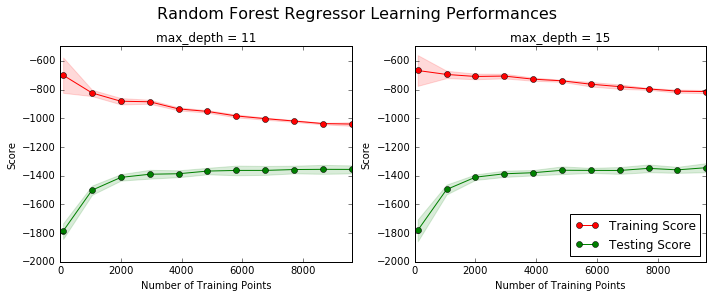

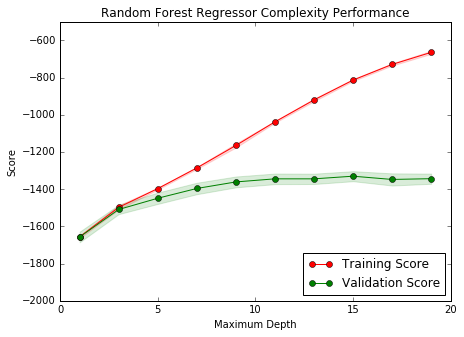

Fitting estimator with 130 features.
Fitting estimator with 90 features.
Fitting estimator with 50 features.
Fitting estimator with 10 features.
Fitting estimator with 130 features.
Fitting estimator with 90 features.
Fitting estimator with 50 features.
Fitting estimator with 10 features.
Fitting estimator with 130 features.
Fitting estimator with 90 features.
Fitting estimator with 50 features.
Fitting estimator with 10 features.
Fitting estimator with 130 features.
Fitting estimator with 90 features.
Fitting estimator with 50 features.
Fitting estimator with 10 features.
Fitting estimator with 130 features.
Fitting estimator with 90 features.
Fitting estimator with 50 features.
Fitting estimator with 10 features.


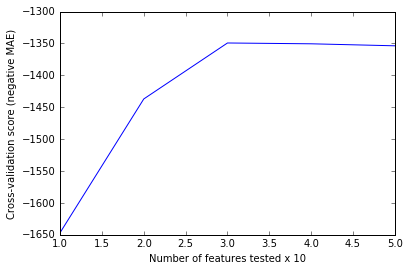

 Ranked features saved:  Allstate-RFECV-ranking.csv

-1349.213 -1427.396
 Optimal number of features: 50
 The selected features are ['cat1', 'cat10', 'cat12', 'cat27', 'cat37', 'cat38', 'cat44', 'cat45', 'cat50', 'cat52', 'cat53', 'cat57', 'cat72', 'cat79', 'cat80', 'cat81', 'cat87', 'cat91', 'cat94', 'cat96', 'cat99', 'cat100', 'cat101', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']

 Time taken: 3 minutes and 23.82 seconds. 



In [8]:
data_slice = 12000
scorer = make_scorer(performance_metric, greater_is_better=True) #False

''' Load Allstate Data'''
start_time = timer(None)
X_train, y_train, train_id, X_test, test_id, all_features = load_data(fix_skew = True, rec_feature_sel = [])
print '\n',X_train.shape, X_test.shape, '\n'
#print '\n',y_train[:5]

''' Plot Learning Curves '''
ModelLearning(X_train[:data_slice], y_train[:data_slice])

''' Plot Complexity Curve (max_depth) '''
ModelComplexity(X_train[:data_slice], y_train[:data_slice])

''' Recursive Feature Selection '''
step = 40
max_depth_opt = 11
rfecv = feature_selection(X_train[:data_slice], y_train[:data_slice], max_depth_opt, step)
print(' Optimal number of features: %d' % rfecv.n_features_)
sel_features = [f for f, s in zip(all_features, rfecv.support_) if s]
print(' The selected features are {}'.format(sel_features))
timer(start_time)